# Abhi Adduri - SC-Interview Task Data Analysis

The following notebook contains code that you can run to reproduce any of the results shown. For the most part, I will use this notebook as a markdown document to analyze the data and show plots easily. My repository also contains standalone scripts with usage guides, which is how I generated my results.

The final comparison across methods as reported below:

| | | | | | | |
|-|-|-|-|-|-|-|
|Method|Features|Micro AUROC|Micro AUPR|Macro AUPR|Micro F1|Macro F1|
|LR|Raw|0.892|0.684|0.603|0.643|0.571|
|RF|Raw|0.960|0.767|0.633|0.679|0.489|
|NN|Raw|0.979|0.852|0.713|0.756|0.644|
|LR|HVG|0.975|0.831|0.670|0.779|0.669|
|RF|HVG|0.971|0.810|0.669|0.722|0.571|
|NN|HVG|**0.989**|**0.920**|**0.783**|**0.837**|**0.700**|
|LR|scGPT|0.973|0.819|0.663|0.765|0.656|
|RF|scGPT|0.972|0.819|0.675|0.727|0.567|
|NN|scGPT|0.988|0.918|0.780|0.832|**0.700**|


A general overview of this notebook:

1. First we will visualize and inspect the data.
2. We will fit baseline classifiers to the data, and a simple neural network, and compute the above metrics.
3. We observe a large gap in the metrics on the training and test sets, so we try alternate featurizations, and see large improvements using the highly-variable genes (HVG), and a foundation model (scGPT).
4. Ideas for future improvements.

All results were separately validated on a cluster with ten different random seeds. The variance of the NN methods across these runs was small (e.g., stddev 0.002 for micro AUPR). The results shown here are for a single train / validation / test split that stratifies the data such that every class is present in each split.



# Setup

If you want to run these scripts on a standalone server and not a colab notebook, you may need to create a conda environment to make sure flash attention installs ok:



```
conda create -n scgpt python=3.9
conda activate scgpt
conda install pip
conda install -c nvidia cuda-toolkit
```

# Imports and load data

In [1]:
# Install package requirements if you want to run in this notebook.
! pip install packaging wandb torch numpy scanpy matplotlib gdown tqdm --quiet
! pip install scgpt "flash-attn<1.0.5" --quiet # This will take a while...

# Clone my fork of the interview repository and chdir into it
! git clone https://github.com/abhinadduri/SC-interview.git
%cd SC-interview

# Make folders to store files for metric visualization down the line
! mkdir plots
! mkdir embeddings

# Download the requisite data
! gdown 1nsmQHdWek4YzIfKs9xUnLBHxKBWu8hUJ -O cells.npy

# Needed to generate embeddings with scGPT foundation model
! gdown https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y -O scgpt --folder
! wget https://github.com/bowang-lab/scGPT/files/13243634/gene_info.csv -P scgpt

# Disable logging to W&B for this colab notebook
%env WANDB_MODE=offline
%env WANDB_SILENT=true

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparin

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from IPython.display import Image

In [3]:
# Create an AnnData object for our data
cells = np.load('cells.npy', allow_pickle=True).item()
adata = sc.AnnData(X=cells['UMI'].toarray(), obs={'cell_type': cells['classes']}, var={'gene_id': cells['gene_ids']})

# Basic preprocessing following scanpy suggestions
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

 # Data Inspection and Visualization

We first want to visually inspect the data to see how separable the cell type clusters are, and also how imbalanced the classes are.

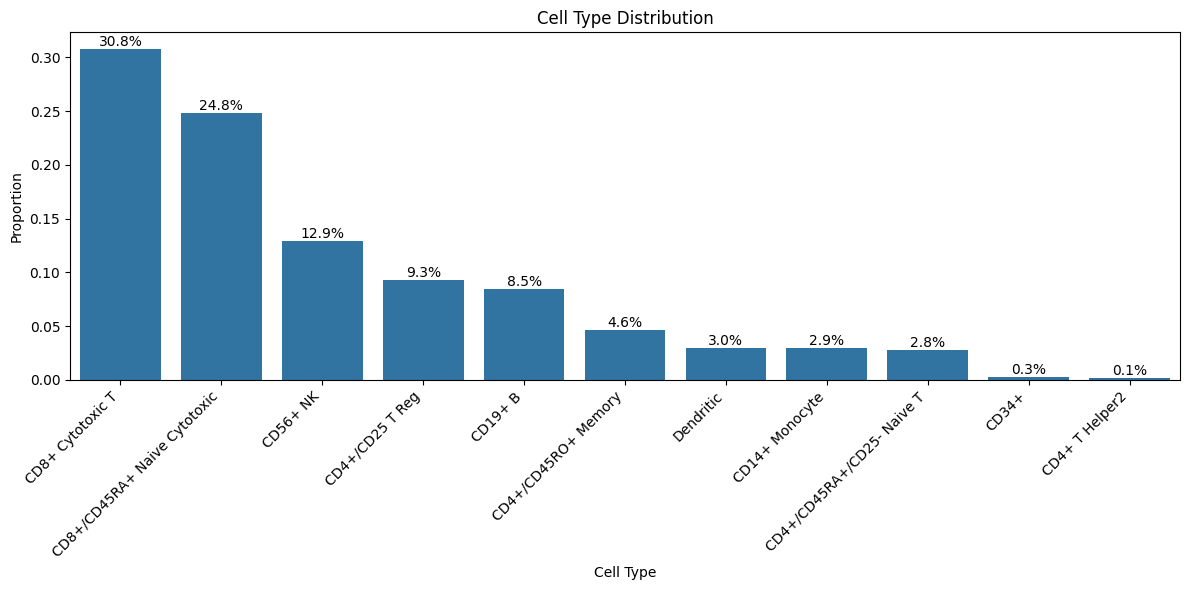

In [5]:
# Calculate the proportion of each cell type
cell_type_counts = adata.obs['cell_type'].value_counts()
cell_type_proportions = cell_type_counts / len(adata)

plt.figure(figsize=(12, 6))
sns.barplot(x=cell_type_proportions.index, y=cell_type_proportions.values)

plt.title('Cell Type Distribution')
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add percentage labels on top of each bar
for i, v in enumerate(cell_type_proportions):
    plt.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.show()


We see that the distribution of labels is very long tailed, and we can expect that classification of CD34+ and CD4+ T Helper2 might be difficult.

Let's also pre-compute several common transforms that scanpy offers to give us more insight into the data. Since most of the gene expression data seems sparse, we can start by computing the set of highly-variable genes.

In [7]:
# Compute common transforms using scanpy
sc.pp.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.pca(adata, svd_solver='arpack')
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Create confusion matrix
cluster_cell_type = pd.crosstab(adata.obs['leiden'], adata.obs['cell_type'])

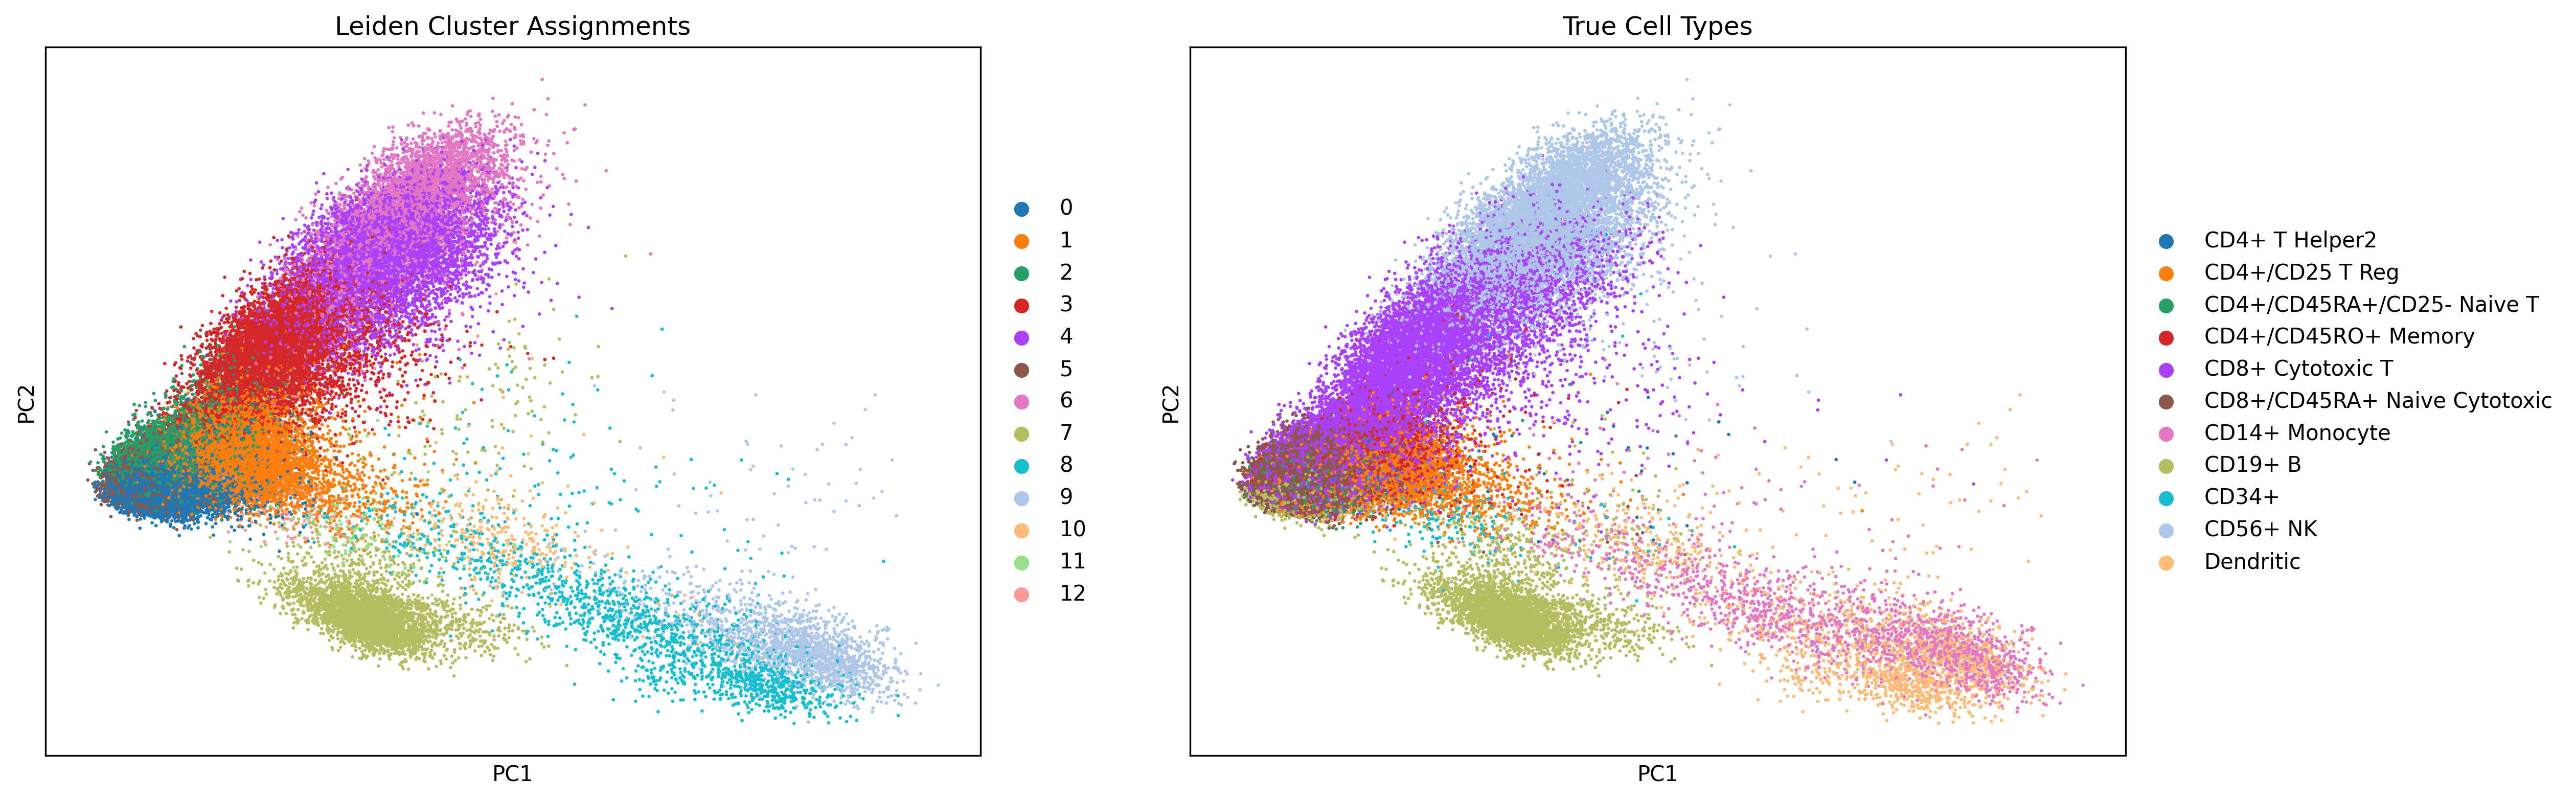

In [117]:
with plt.rc_context({"figure.figsize": (8, 6), "figure.dpi": (300)}):
    sc.pl.pca(adata, color=['leiden', 'cell_type'], title=['Leiden Cluster Assignments', 'True Cell Types'], size=10)

From here we see there is quite a large overlap with CD56+ NK and CD8+ Cytotoxic T. There is also a blob of similar looking points consisting of CD8+ Cytotoxic T, CD8+/CD45RA + Naive Cytotoxic, CD19+ B, and CD4+/CD25T Reg, suggesting these classes may be difficult to discriminate.

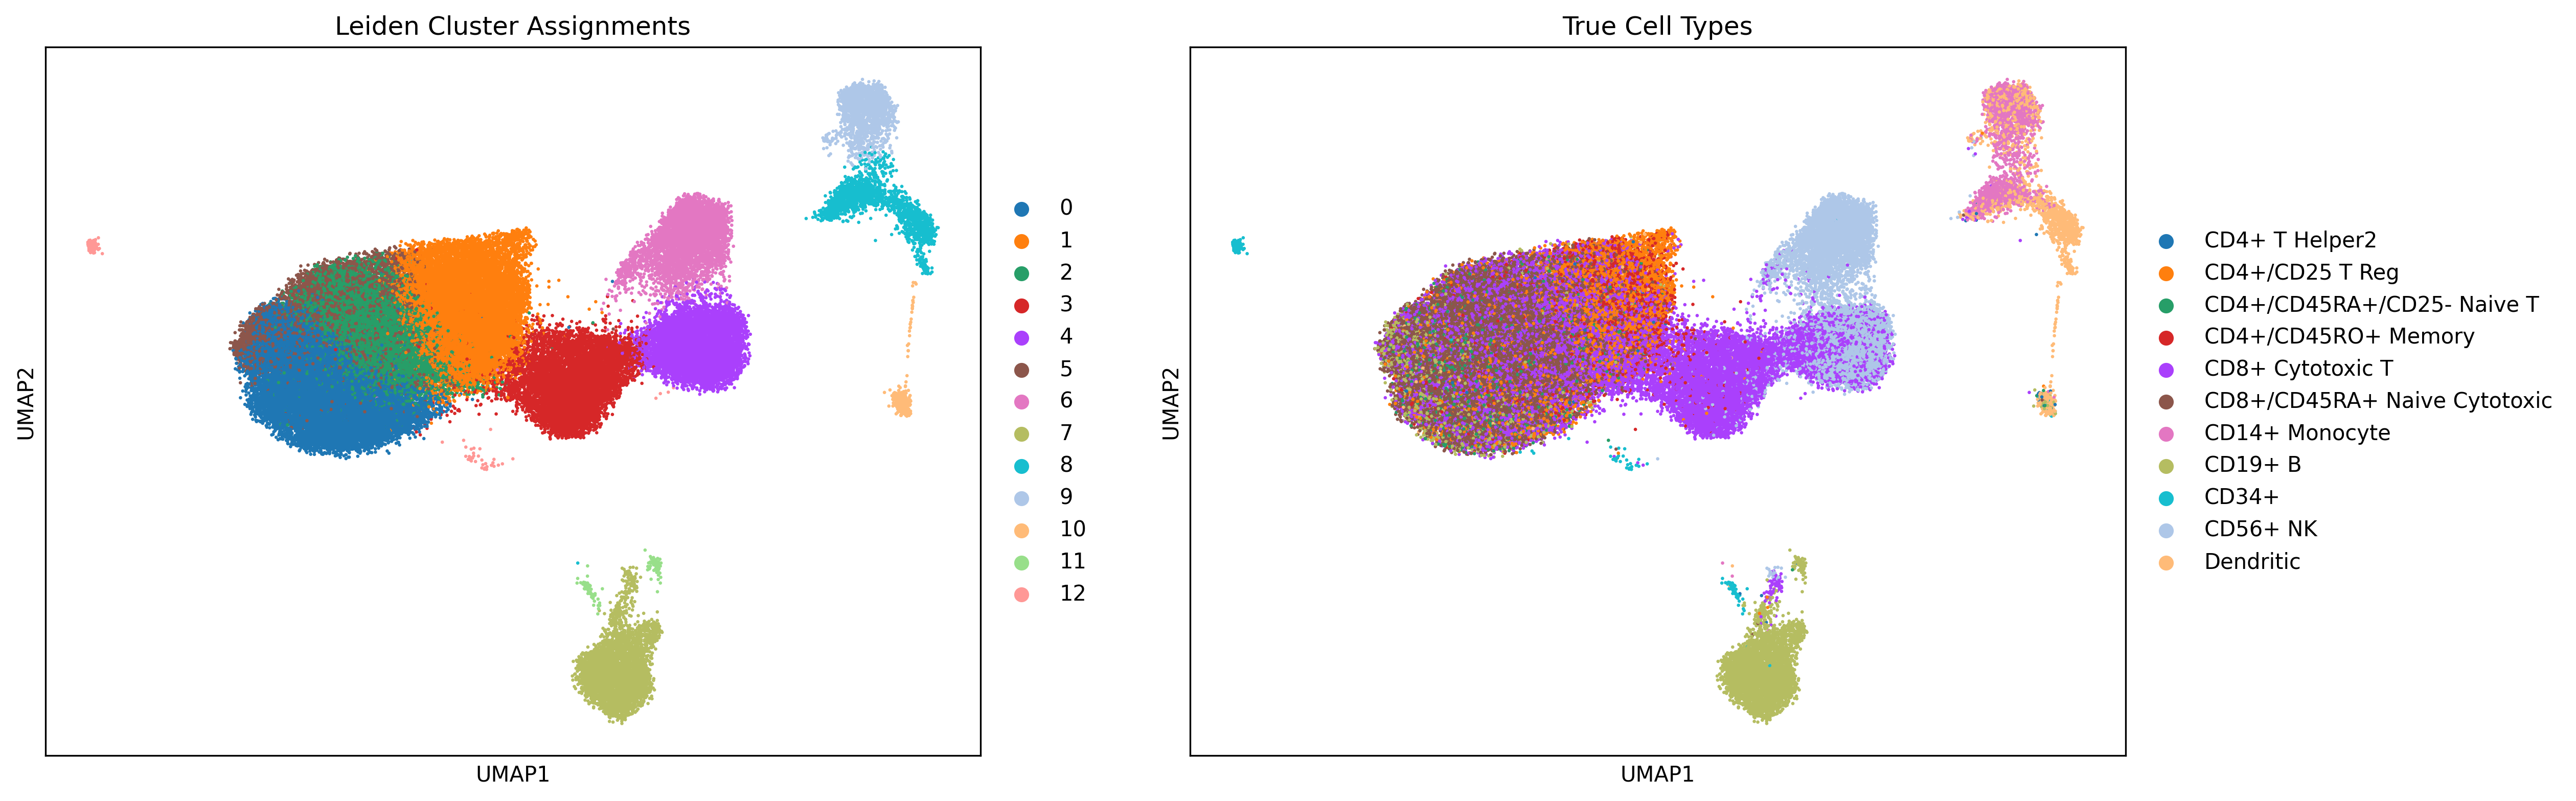

In [116]:
with plt.rc_context({"figure.figsize": (8, 6), "figure.dpi": (300)}):
    sc.pl.umap(adata, color=['leiden', 'cell_type'], title=['Leiden Cluster Assignments', 'True Cell Types'], size=10)

Lastly let's take a look at a confusion matrix of the clusters vs the true cell type annotations.

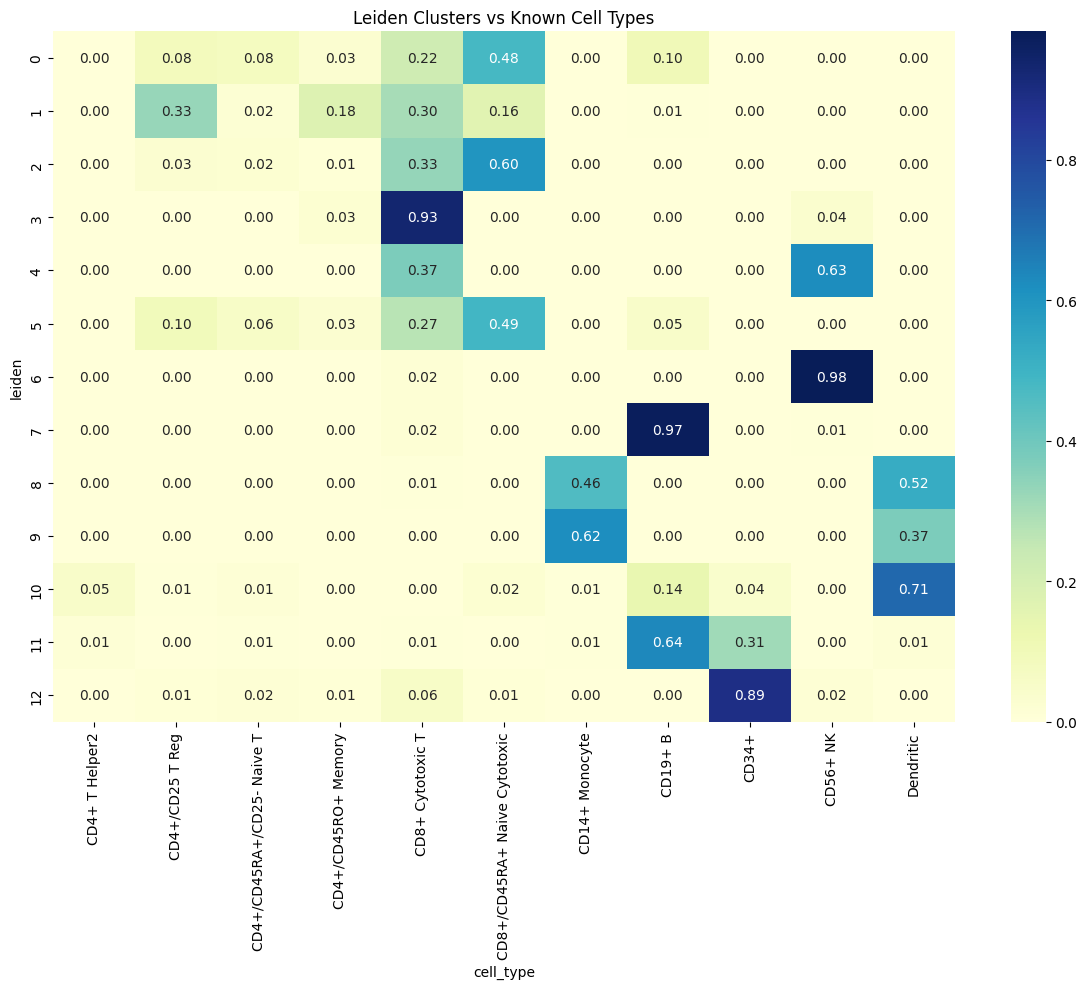

In [123]:
confusion_matrix = pd.crosstab(adata.obs['leiden'], adata.obs['cell_type'], normalize='index')
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Leiden Clusters vs Known Cell Types')
plt.tight_layout()
plt.show()

This shows that a few cell types appear across a lot of clusters. Furthermore, cells like CD4+ T Helper2 are co-located with Dendritic cells in PCA space, and CD4+/CD45A+/CD25- Naive T are co-located with CD8+/CD45A+ naive Cytotoxic cells, which will likely make their discrimination difficult.

# Baseline Models

Let's start by computing some baselines on the raw data. This will be expensive but can guide our analysis. We will train a logistic regression model, a random forest classifier, and a simple neural network on the normalized data. For these baselines we will use the balanced class weight option to address the cell type imbalance in our dataset.

In [44]:
! python train.py --method lr --verbose


Provided featurization has (65943, 16769) shape for X and (65943,) shape for y

Results for the test set:
	 	precision	recall	f1-score	support
CD14+ Monocyte	0.7772151898734178	0.850415512465374	0.8121693121693122	361.0
CD19+ B	0.7467411545623837	0.7059859154929577	0.72579185520362	1136.0
CD34+	0.9565217391304348	0.6875	0.8	32.0
CD4+ T Helper2	0.0	0.0	0.0	18.0
CD4+/CD25 T Reg	0.48839071257005606	0.5012325390304027	0.4947283049472831	1217.0
CD4+/CD45RA+/CD25- Naive T	0.30930930930930933	0.2853185595567867	0.29682997118155624	361.0
CD4+/CD45RO+ Memory	0.31647940074906367	0.2779605263157895	0.29597197898423816	608.0
CD56+ NK	0.8445984979780474	0.8450867052023121	0.8448425310603872	1730.0
CD8+ Cytotoxic T	0.6223404255319149	0.6526800873150619	0.6371492837693855	4123.0
CD8+/CD45RA+ Naive Cytotoxic	0.6499841621792841	0.6376631448104413	0.6437647058823529	3218.0
Dendritic	0.7701149425287356	0.6961038961038961	0.7312414733969985	385.0
accuracy	0.6434149670179695	0.6434149670179695	0.643414967

In [23]:
! python train.py --method rf --verbose


Provided featurization has (65943, 16769) shape for X and (65943,) shape for y

Results for the test set:
	 	precision	recall	f1-score	support
CD14+ Monocyte	0.7017241379310345	0.9667458432304038	0.8131868131868132	421.0
CD19+ B	0.9840213049267643	0.662780269058296	0.7920685959271169	1115.0
CD34+	1.0	0.3888888888888889	0.56	36.0
CD4+ T Helper2	0.0	0.0	0.0	18.0
CD4+/CD25 T Reg	0.7032640949554896	0.18824463860206514	0.29699248120300753	1259.0
CD4+/CD45RA+/CD25- Naive T	0.0	0.0	0.0	382.0
CD4+/CD45RO+ Memory	0.0	0.0	0.0	580.0
CD56+ NK	0.8544627629334849	0.8946428571428572	0.8740913056120966	1680.0
CD8+ Cytotoxic T	0.6398616515348032	0.7235394769005133	0.6791327291499368	4091.0
CD8+/CD45RA+ Naive Cytotoxic	0.5900061437640794	0.8994692475803934	0.7125896611427157	3203.0
Dendritic	0.8781512605042017	0.5173267326732673	0.6510903426791277	404.0
accuracy	0.6785957995299113	0.6785957995299113	0.6785957995299113	0.6785957995299113
macro avg	0.5774083051408961	0.4765125412796987	0.4890138117182558

Now that we have baselines, let's see if a neural network approach can improve our results.

Provided featurization has (65943, 16769) shape for X and (65943,) shape for y
wandb: Tracking run with wandb version 0.17.5
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
Training: 100% 50/50 [01:06<00:00,  1.33s/epoch, Train Loss=0.0737, Val Loss=1.0228]
Results for the train set:
	 	precision	recall	f1-score	support
CD14+ Monocyte	0.9993654822335025	1.0	0.999682640431609	1575.0
CD19+ B	0.9993364299933643	0.9997787121044479	0.9995575221238938	4519.0
CD34+	0.9806451612903225	1.0	0.990228013029316	152.0
CD4+ T Helper2	1.0	0.44	0.6111111111111112	75.0
CD4+/CD25 T Reg	0.9987883683360258	0.9983851433185305	0.9985867151221482	4954.0
CD4+/CD45RA+/CD25- Naive T	0.9960079840319361	0.995345744680851	0.9956767542401064	1504.0
CD4+/CD45RO+ Memory	0.9927095990279465	0.9983706720977596	0.9955320877335501	2455.0
CD56+ NK	0.9991309385863267	0.9992756772417789	0.9992033026725574	6903.0
CD8+ Cytotoxic T	0.99919304

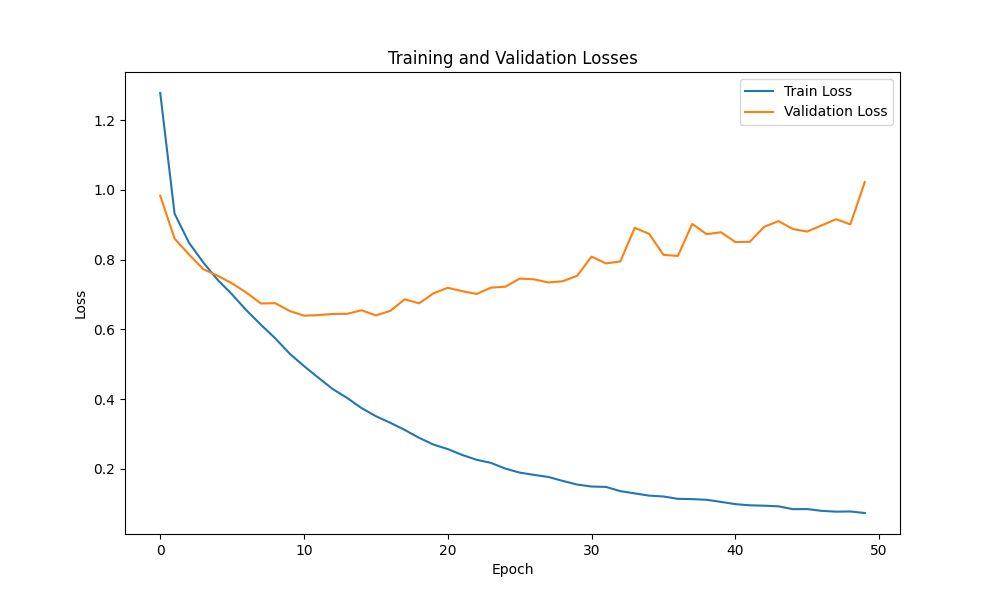

In [21]:
! python train.py --method nn --verbose --loss-plot plots/raw_nn_loss_50.png
Image('plots/raw_nn_loss_50.png', width=720, height=432)

We overfit very heavily! Let's try 10 epochs instead (early stopping).

Provided featurization has (65943, 16769) shape for X and (65943,) shape for y
Training: 100% 10/10 [00:13<00:00,  1.33s/epoch, Train Loss=0.5307, Val Loss=0.6529]
Results for the train set:
	 {'train_loss': 0.4206043779850006, 'micro_auroc': 0.9929624882242312, 'micro_aupr': 0.9444357038880338, 'macro_aupr': 0.8410972863940575, 'micro_f1': 0.8668114503959711, 'macro_f1': 0.7508997018670788}
Results for the val set:
	 {'val_loss': 0.6529132723808289, 'micro_auroc': 0.9787925426322368, 'micro_aupr': 0.8547440510131012, 'macro_aupr': 0.6927198685485871, 'micro_f1': 0.75787700084246, 'macro_f1': 0.6245658873863686}
Results for the test set:
	 {'test_loss': 0.6578068733215332, 'micro_auroc': 0.9785791554127263, 'micro_aupr': 0.8519300630658467, 'macro_aupr': 0.713008420342057, 'micro_f1': 0.7561789234268386, 'macro_f1': 0.6438708079079732}
wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more 

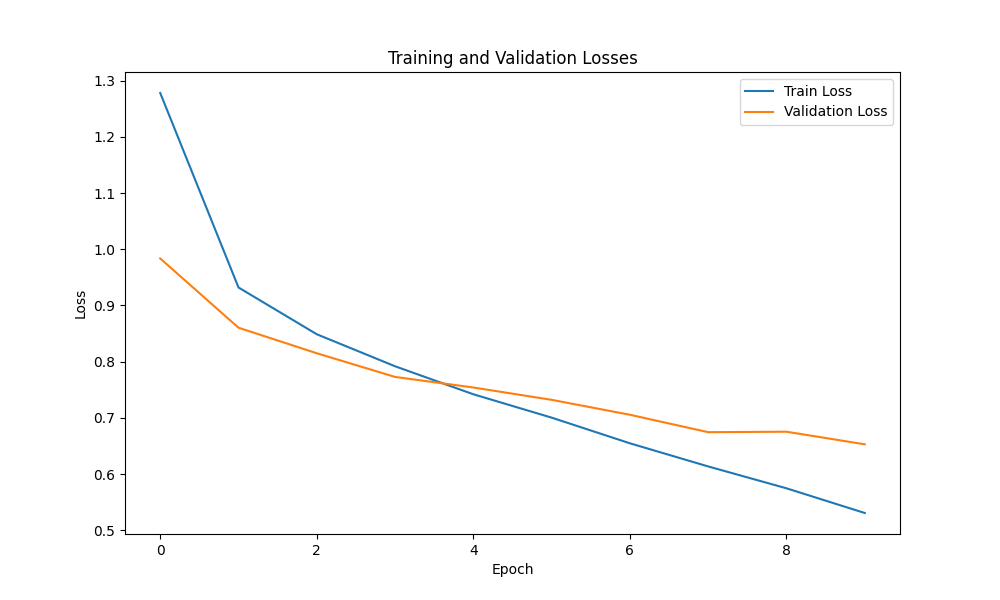

In [38]:
! python train.py --method nn --epochs 10 --loss-plot plots/raw_nn_loss_10.png
Image('plots/raw_nn_loss_10.png', width=720, height=432)

Let's visualize ROC and PR curves for the three classifiers.

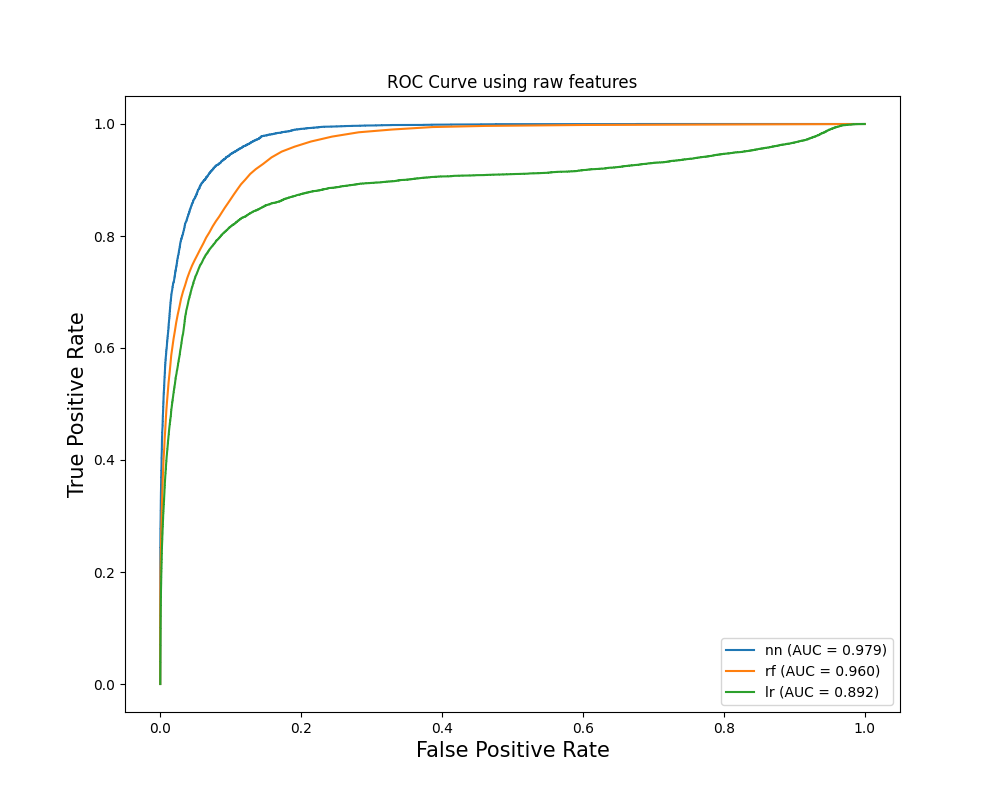

<Figure size 640x480 with 0 Axes>

In [43]:
%run utils.py # this gives us a plot_curves helper function
methods = ['nn', 'rf', 'lr']
plot_curves(methods, 'roc', title="ROC Curve using raw features")
plot_curves(methods, 'prc', title="Precision-Recall Curve using raw features")
Image('plots/roc_comparison.png')

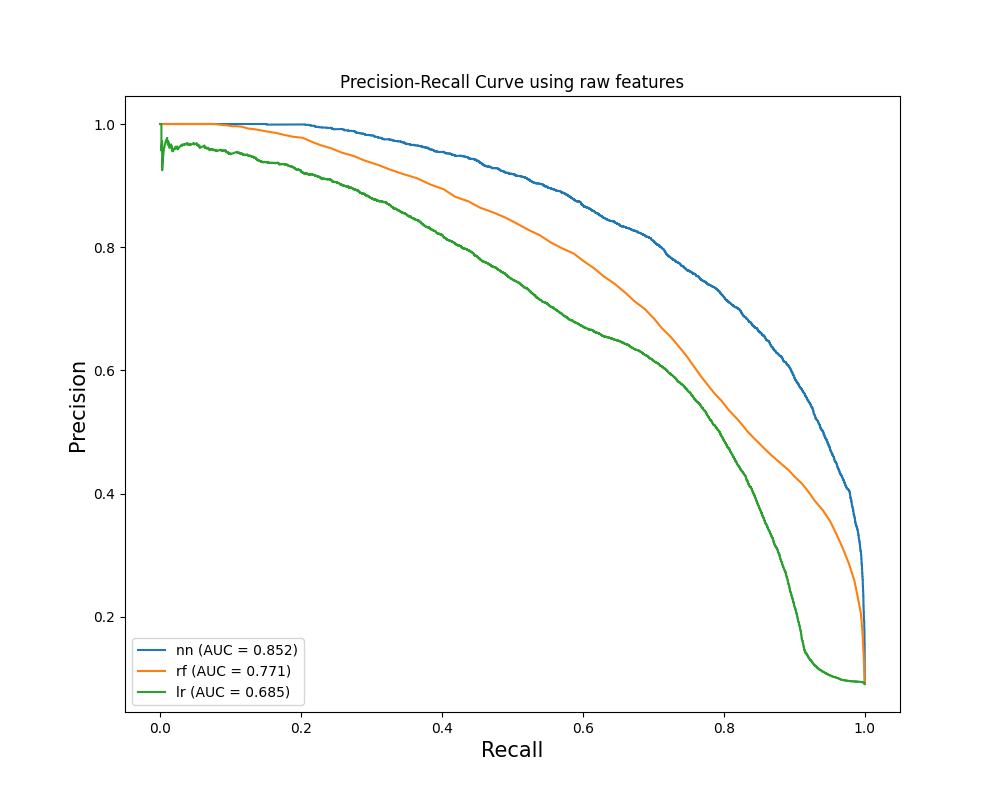

In [34]:
Image('plots/prc_comparison.png')

# Addressing overfitting by removing non-variable genes

Our neural network above has much higher AUPR on the training data than on the test data, meaning the generalization gap is large. Since we know that only a subset of our genes are highly variable, e.g. explain the variance in our dataset, let's try training on only those genes.

In [39]:
! python embed.py --featurizer hvg --out-file hvg_embeddings.h5ad

/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/usr/local/lib/python3.10/dist-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
Computing highly variable genes...


We can re-run benchmarks and compute new ROC and PR curves, using the hvg embeddings as features.

In [45]:
! python train.py --method lr --data hvg_embeddings.h5ad
! python train.py --method rf --data hvg_embeddings.h5ad

Provided featurization has (65943, 1800) shape for X and (65943,) shape for y
Results for the test set:
Results for the test set:
	 {'micro_auroc': 0.9749110044425643, 'micro_aupr': 0.831029580736889, 'macro_aupr': 0.6704593496318331, 'micro_f1': 0.779226686884003, 'macro_f1': 0.668796267774344}
Provided featurization has (65943, 1800) shape for X and (65943,) shape for y
Results for the test set:
Results for the test set:
	 {'micro_auroc': 0.9706814464745444, 'micro_aupr': 0.8104784583858283, 'macro_aupr': 0.6685477865256043, 'micro_f1': 0.7223654283548142, 'macro_f1': 0.5706664714120918}


Provided featurization has (65943, 1800) shape for X and (65943,) shape for y
Training: 100% 50/50 [01:03<00:00,  1.26s/epoch, Train Loss=0.4212, Val Loss=0.4383]
Results for the train set:
	 {'train_loss': 0.36292052268981934, 'micro_auroc': 0.9931762614434989, 'micro_aupr': 0.9469621935059652, 'macro_aupr': 0.8485992910942652, 'micro_f1': 0.8716230131241458, 'macro_f1': 0.7492545094846439}
Results for the val set:
	 {'val_loss': 0.4383322596549988, 'micro_auroc': 0.9900036636718054, 'micro_aupr': 0.92484008024682, 'macro_aupr': 0.7889825161902806, 'micro_f1': 0.84212299915754, 'macro_f1': 0.7087582045595039}
Results for the test set:
	 {'test_loss': 0.45920440554618835, 'micro_auroc': 0.9890710586109243, 'micro_aupr': 0.9196806324115885, 'macro_aupr': 0.7827538970230132, 'micro_f1': 0.8366944655041698, 'macro_f1': 0.6995849023613055}
wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more 

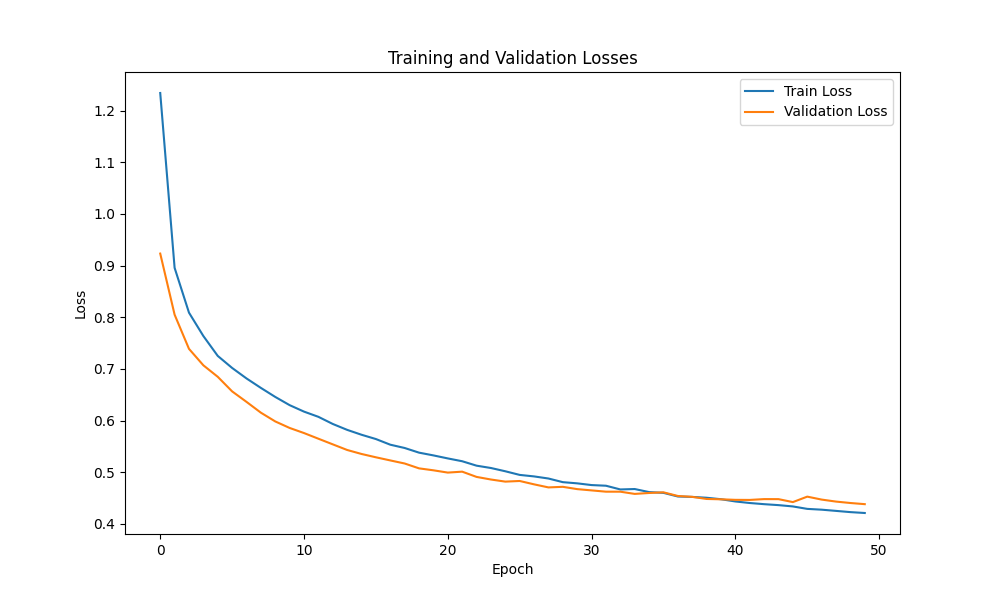

In [46]:
! python train.py --method nn --data hvg_embeddings.h5ad --loss-plot plots/hvg_nn_loss_50.png
Image('plots/hvg_nn_loss_50.png', width=720, height=432)

The validation curve is likely lower than the training curve for two reasons. First, we use dropout in evaluation but not training, which increases training loss. Second, the eval loss is computed after a whole epoch, whereas the training loss is aggregated per batch in the epoch. To verify nothing strange is going on, let's use the --recompute-train-loss flag.

Provided featurization has (65943, 1800) shape for X and (65943,) shape for y
Training: 100% 50/50 [01:02<00:00,  1.25s/epoch, Train Loss=0.3629, Val Loss=0.4383]
Results for the train set:
	 {'train_loss': 0.36292052268981934, 'micro_auroc': 0.9931762614434989, 'micro_aupr': 0.9469621935059652, 'macro_aupr': 0.8485992910942652, 'micro_f1': 0.8716230131241458, 'macro_f1': 0.7492545094846439}
Results for the val set:
	 {'val_loss': 0.4383322596549988, 'micro_auroc': 0.9900036636718054, 'micro_aupr': 0.92484008024682, 'macro_aupr': 0.7889825161902806, 'micro_f1': 0.84212299915754, 'macro_f1': 0.7087582045595039}
Results for the test set:
	 {'test_loss': 0.45920440554618835, 'micro_auroc': 0.9890710586109243, 'micro_aupr': 0.9196806324115885, 'macro_aupr': 0.7827538970230132, 'micro_f1': 0.8366944655041698, 'macro_f1': 0.6995849023613055}
wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more 

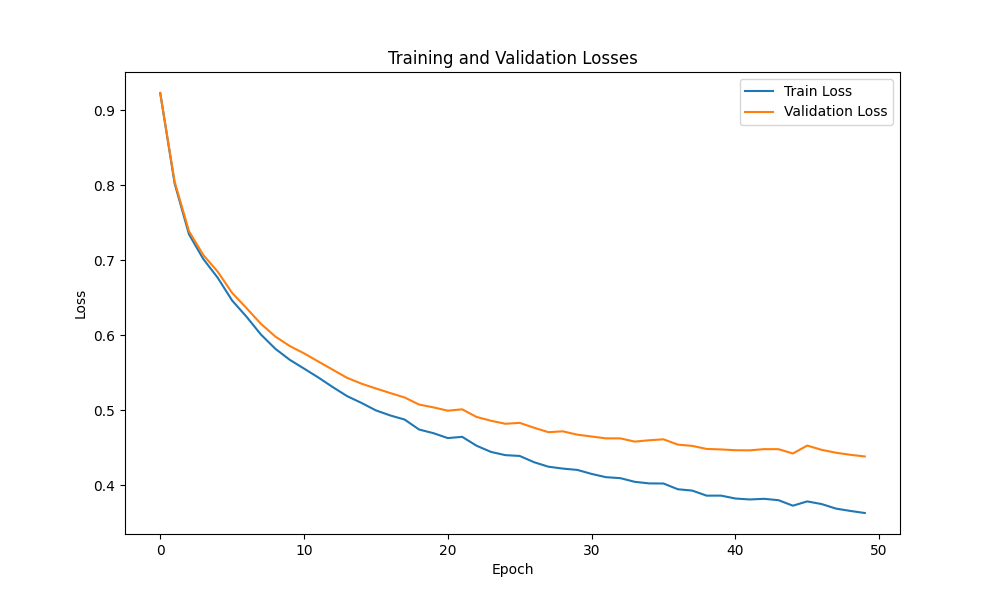

In [50]:
! python train.py --method nn --data hvg_embeddings.h5ad --loss-plot plots/hvg_nn_loss_50_corrected.png --recompute-train-loss
Image('plots/hvg_nn_loss_50_corrected.png', width=720, height=432)

Things make sense again now 🙂 . Let's recompute ROC and PR curves.

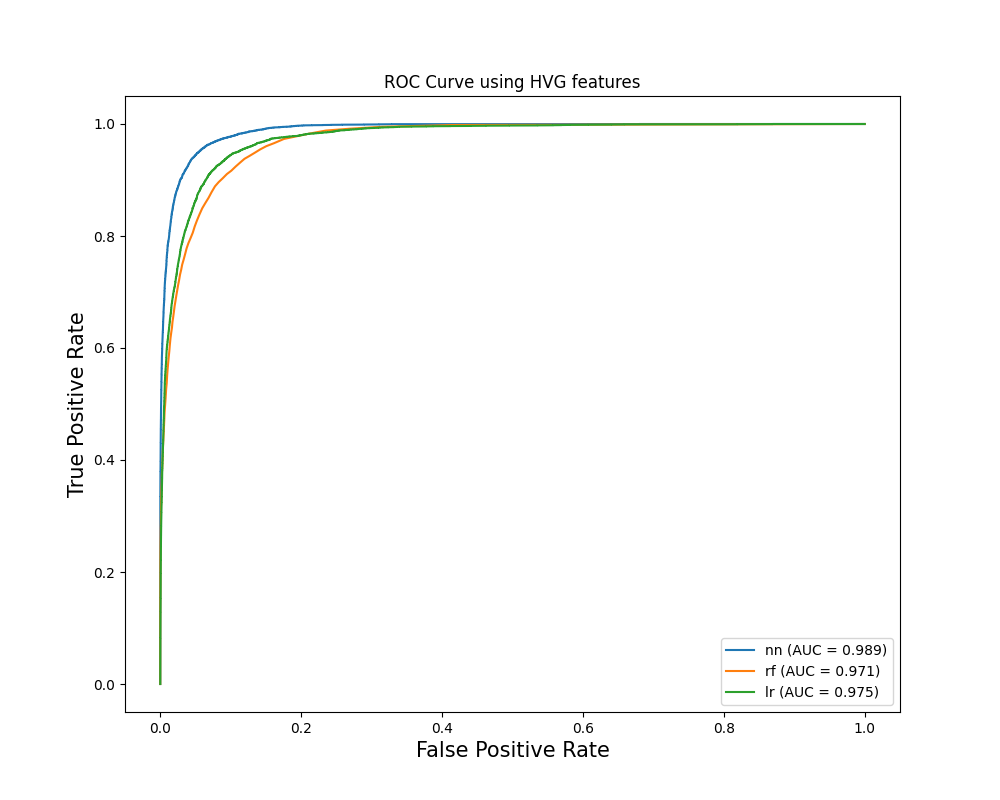

<Figure size 640x480 with 0 Axes>

In [54]:
%run utils.py # this gives us a plot_curves helper function
methods = ['nn', 'rf', 'lr']
plot_curves(methods, 'roc', title="ROC Curve using HVG features")
plot_curves(methods, 'prc', title="Precision-Recall Curve using HVG features")
Image('plots/roc_comparison.png')

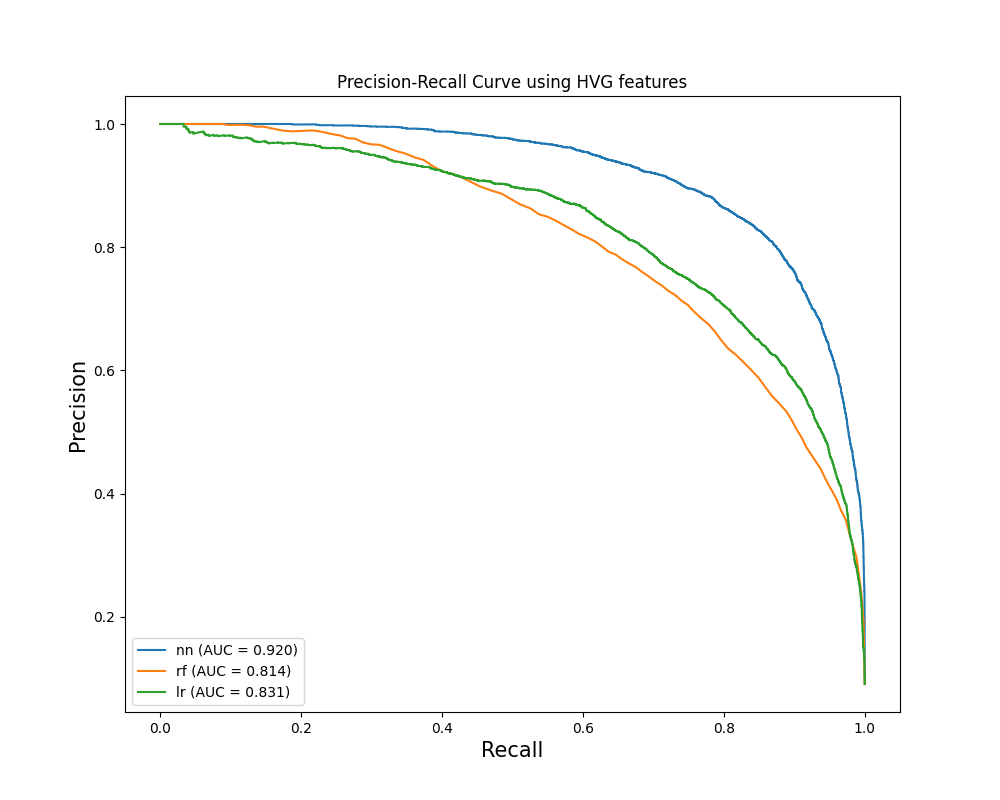

In [55]:
Image('plots/prc_comparison.png')

All methods are greatly improved by considering only the highly variable genes! Removing the sparse genes likely helps the learning algorithms focus on what's important.

# Using scGPT foundation model embeddings

Lastly, let's try using a foundation model developed for single-cell data. Here we use scGPT to compute gene embeddings and train on those.

In [40]:
! python embed.py --featurizer scgpt --out-file scgpt_embeddings.h5ad

/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/usr/local/lib/python3.10/dist-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
Computed highly variable genes
/content/SC-interview/embed.py:82: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[gene_col] = adata.var['gene_id'].apply(lambda id: ensembl_df.loc[id, 'feature_name'] if id in ensembl_df.index else id)
Converted ENSEMBL IDs to gene symbols
scGPT - INFO - match 1717/1800 genes in vocabulary of size 60697.
/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100% 1

In [56]:
! python train.py --method lr --data scgpt_embeddings.h5ad
! python train.py --method rf --data scgpt_embeddings.h5ad

Provided featurization has (65943, 1717) shape for X and (65943,) shape for y
Results for the test set:
Results for the test set:
	 {'micro_auroc': 0.9725809073775076, 'micro_aupr': 0.819081701601465, 'macro_aupr': 0.6630551038859934, 'micro_f1': 0.7645185746777862, 'macro_f1': 0.6556460027833362}
Provided featurization has (65943, 1717) shape for X and (65943,) shape for y
Results for the test set:
Results for the test set:
	 {'micro_auroc': 0.9717497150470669, 'micro_aupr': 0.8190467663337506, 'macro_aupr': 0.6752539992124774, 'micro_f1': 0.7272175890826383, 'macro_f1': 0.5668239398920665}


This time we can visualize the embeddings from our trained model.

Provided featurization has (65943, 1717) shape for X and (65943,) shape for y
Training: 100% 100/100 [02:06<00:00,  1.27s/epoch, Train Loss=0.3719, Val Loss=0.4500]
Results for the train set:
	 	precision	recall	f1-score	support
CD14+ Monocyte	0.9165628891656289	0.9346031746031747	0.9254951273184533	1575.0
CD19+ B	0.9508335688047471	0.7446337685328612	0.8351948374286423	4519.0
CD34+	0.9931972789115646	0.9605263157894737	0.9765886287625417	152.0
CD4+ T Helper2	1.0	0.10666666666666667	0.1927710843373494	75.0
CD4+/CD25 T Reg	0.758418463866818	0.809245054501413	0.7830078125000001	4954.0
CD4+/CD45RA+/CD25- Naive T	0.748641304347826	0.3663563829787234	0.49196428571428574	1504.0
CD4+/CD45RO+ Memory	0.7305835892935498	0.6782077393075356	0.7034220532319392	2455.0
CD56+ NK	0.9851301115241635	0.9213385484571925	0.9521670783741298	6903.0
CD8+ Cytotoxic T	0.8797674418604651	0.9199902723735408	0.8994293865905849	16448.0
CD8+/CD45RA+ Naive Cytotoxic	0.8353841946951053	0.9221249622698461	0.87661406025

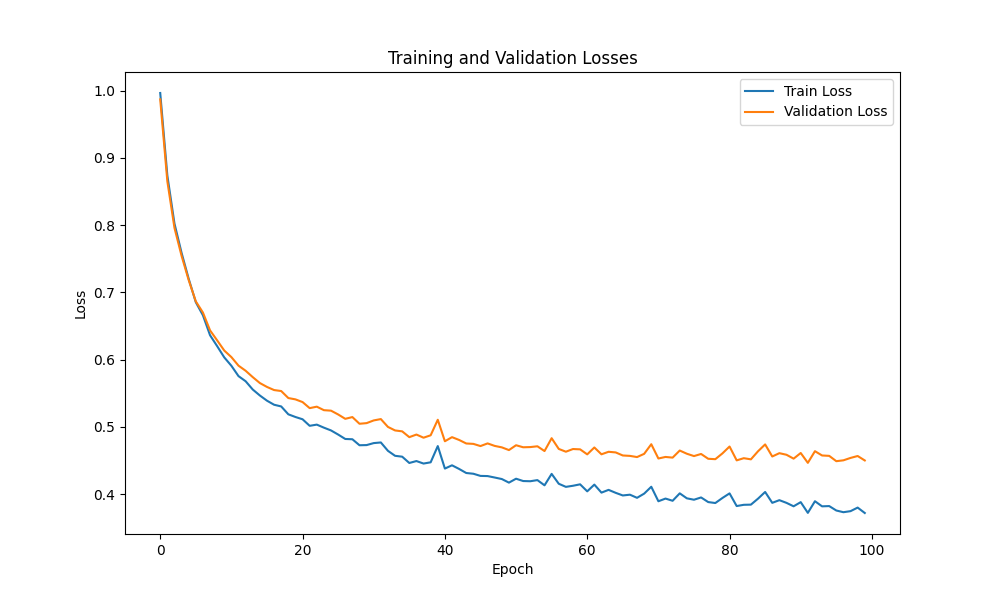

In [64]:
! python train.py --method nn --data scgpt_embeddings.h5ad --loss-plot scgpt_nn_loss.png --epochs 100 --output-latents embeddings/scgpt_nn.npz --recompute-train-loss --verbose
Image('scgpt_nn_loss.png', width=720, height=432)

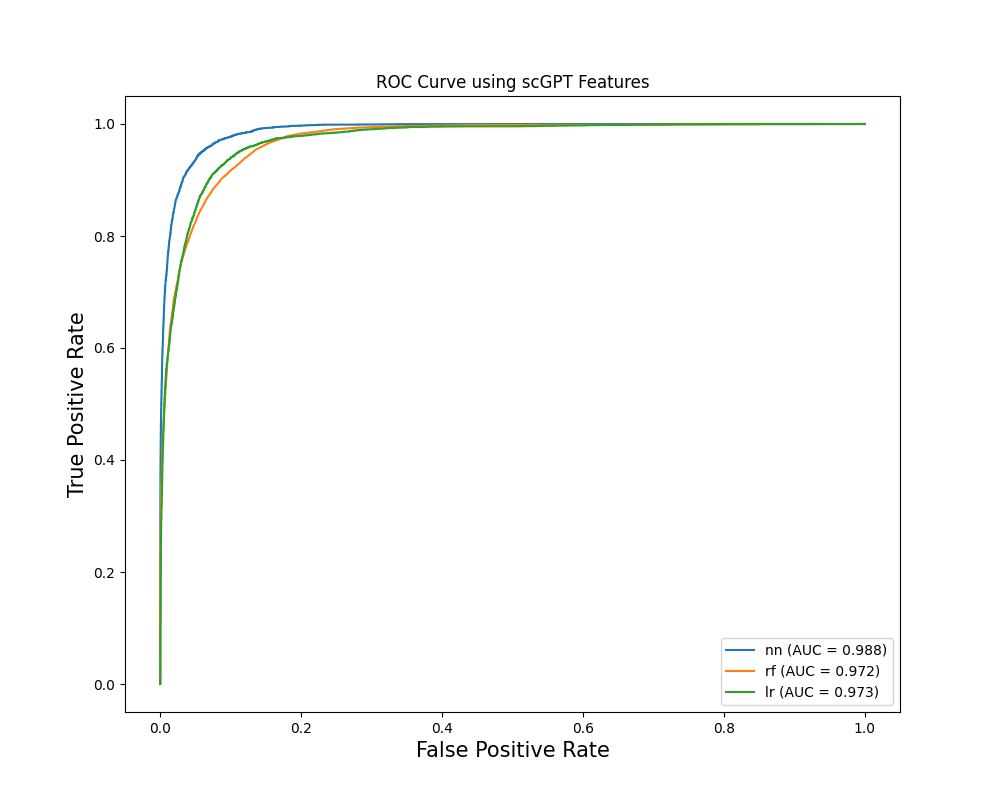

<Figure size 640x480 with 0 Axes>

In [58]:
%run utils.py # this gives us a plot_curves helper function
methods = ['nn', 'rf', 'lr']
plot_curves(methods, 'roc', title="ROC Curve using scGPT Features")
plot_curves(methods, 'prc', title="Precision-Recall Curve using scGPT Features")
Image('plots/roc_comparison.png')

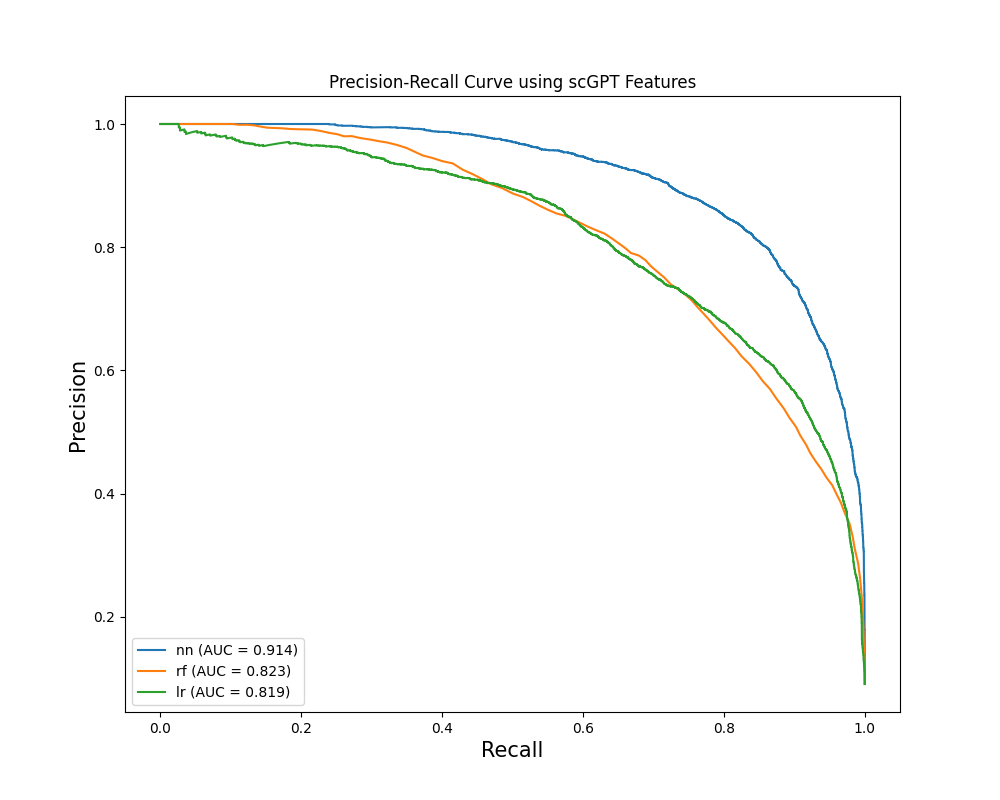

In [59]:
Image('plots/prc_comparison.png')

Interestingly, the foundation model performs **worse** than simply using the highly variable genes! This is worth further analysis.

# Visualizing the embedding space

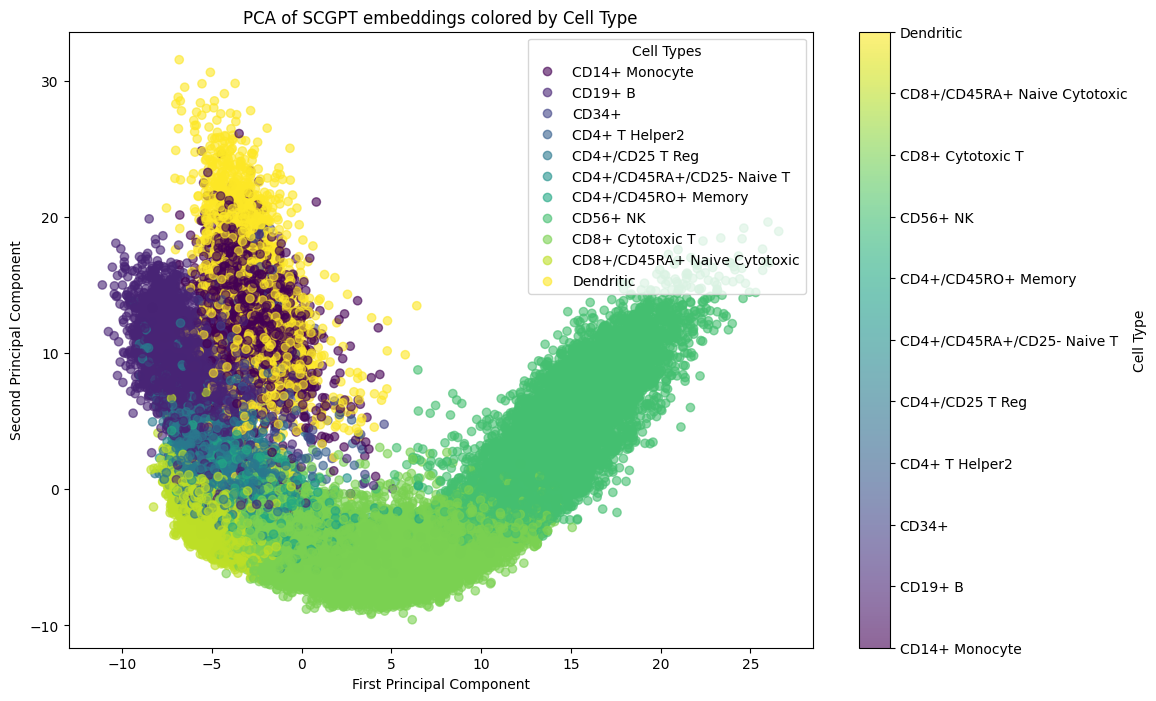

In [60]:
from sklearn.decomposition import PCA

e = np.load('embeddings/scgpt_nn.npz', allow_pickle=True)

# Compute the top two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(e['latents'])
cell_names_cat = pd.Categorical(e['cell_names'])
codes = cell_names_cat.codes

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=codes, cmap='viridis', alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of SCGPT embeddings colored by Cell Type')

# Add a color bar and cell types
cbar = plt.colorbar(scatter)
cbar.set_label('Cell Type')
cbar.set_ticks(range(len(cell_names_cat.categories)))
cbar.set_ticklabels(cell_names_cat.categories)

# Add legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, cell_names_cat.categories, loc="upper right", title="Cell Types")

# Save the plot
plt.show()

# Takeaways and future directions to improve

1. It's interesting that the embeddings from the foundation model perform worse than simply filtering for the highly variable genes. This is something worth looking into further. It's possible that there is a pre-train vs fine-tune mismatch here, as I used the **whole-human (recommended)** model that was pre-trained on 33 million normal human cells. It's possible that the **continual pretrained** model, described by the authors to be used "for zero-shot cell embedding related tasks", would be a better fit.

2. The visualized embedding space shows that there is still quite some overlap between different cell types. Introducing a supervised contrastive loss on the embedding space may improve generalization.

3. Simple methods applied correctly can often lead to good results. In this case, training a simple neural network with appropriate dropout and batch normalization resulted in the best performing method.

4. Though I didn't explore this much, we could consider class weighing or resampling techniques to improve performance on the minority classes. We overfit on **CD4+ T Helper2**, which is the least represented class, but perform well on **CD34+**, the second least represented class, suggesting that CD34+ is easier to discriminate. We also perform poorly on **CD4+/CD45RA+/CD25- Naive T** and **CD4+/CD45RO+ Memory**, which also makes sense looking at the confusion matrix below.

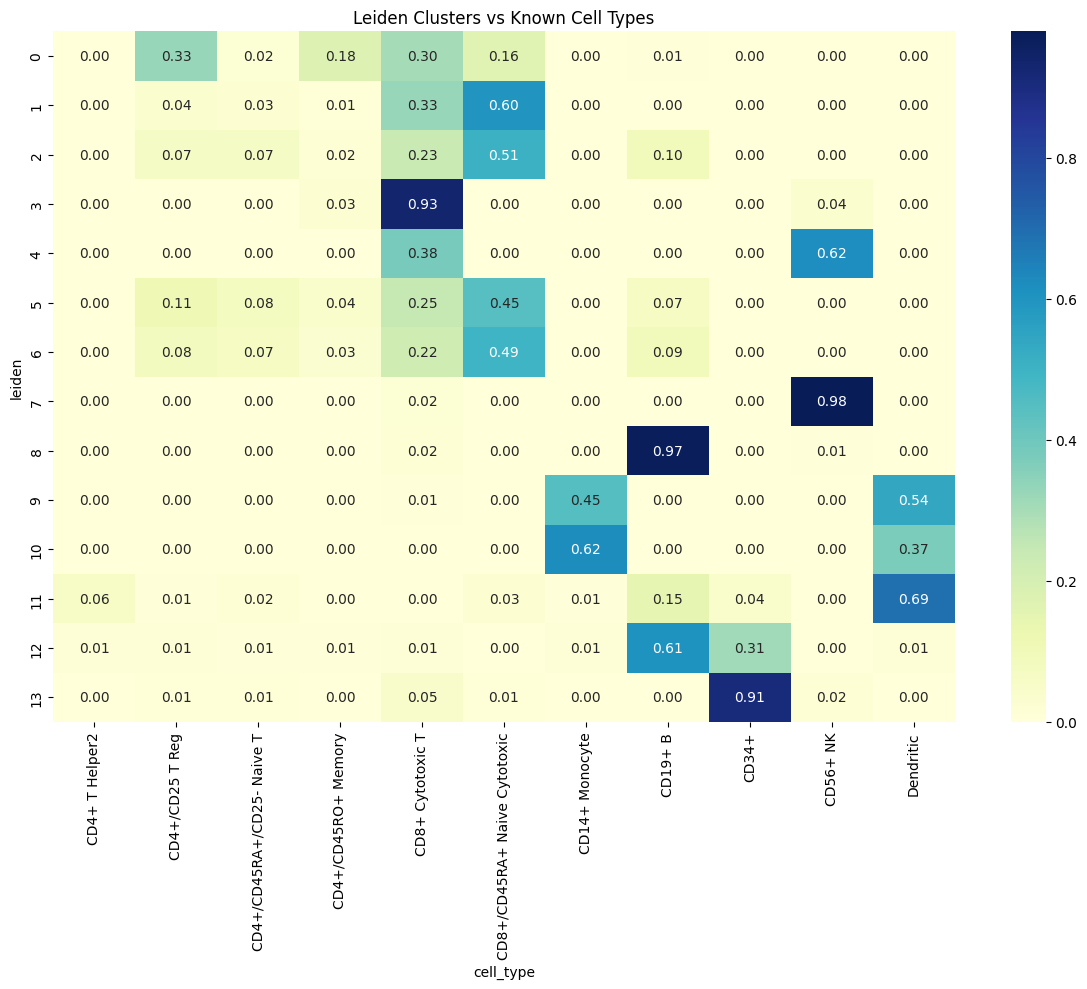

In [62]:
confusion_matrix = pd.crosstab(adata.obs['leiden'], adata.obs['cell_type'], normalize='index')
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Leiden Clusters vs Known Cell Types')
plt.tight_layout()
plt.show()